# Assignment

We saw a few examples of machine learning algorithms, so at this point it seems like once you get the data ready, machine learning is just "plug and play", but not so fast! 

In this assignment, we learn about **regularization**! Regularization is a means by which we can control how much a machine learning algorithm learns. The controlling is done using a parameter that the algorithm, called the **shrinkage parameter**, which is just an argument of the algorithm. The shrinkage parameter is an example of a **hyper-parameter**. A hyper-parameter is like a knob: by specifying a different value for the hyper-parameter, we control how the training happens, a process called **hyper-parameter tuning**. We talk about this is more detail in the next lesson.

We will look at two examples of regularizaiton: LASSO and Ridge regression. Both LASSO and Ridge regression are implementations of linear regression where we try to minimize prediction error plus some penalty that depends on the model's parameters (or coefficients) and the shrinkage constant (`alpha` in the code below). LASSO penalizes the model's parameters using the sum of the **absolute values** of the parameters (this is also called **L1-regularization**), while Ridge does so based on the sum of the **squared values** of the parameters (this is also called **L2-regularization**). For reasons we cannot elaborate on here, **LASSO has the by-product that it also does feature selection**, whereas Ridge doesn't. So not all regularization results in feature selection.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.svm import SVR

## Root Mean Squared Error (RMSE)
Before we dive into regularization we need to have a metric that tells us if our regression is good or bad.  For regressions we measure success differently than with classifications.  Instead of accuracy, the primary measure is **Root Mean Squared Error** (**RMSE**).  A **RMSE** of zero occurs when the predictions are perfect. **RMSE** increases as the predictions get worse. Let's disect the term **Root Mean Squared Error** by understanding each word from right to left.

### Error
The **E** in **RMSE** stands for **E**rror ($e_i$).  The error ($e_i$) is the difference between the known test target value ($y_i$) of sample $i$ and the predicted target value ($\hat{y}_i$) based on the test inputs of sample $i$.
$$e_i = y_i - \hat{y}_i$$
where
- $e_i$ is the error of the $i$th sample
- $y_i$ is the test target value of the $i$th sample
- $\hat{y}_i$ is the predicted target value from the inputs of the $i$th sample

### Squared
The **S** in **RMSE** stands for squared.  The errors ($e_i$) are squared: $(e_i)^2$.  

### Mean
The **M** in **RMSE** stands for mean.  We get the mean squared error (**MSE**) by taking the mean of all the squared errors in the sample:
$$\text{MSE} = \frac{1}{n}\sum_{i}(e_i)^2$$
where
- $\text{MSE}$ is the mean squared error
- $n$ is the number of samples

### Root
The **R** in **RMSE** stands for root.  We get the root mean squared error (**RMSE**) by taking the square root mean of **MSE**
$$\text{RMSE} = \sqrt{\text{MSE}}$$

Both **MSE** and **RMSE** are used to measure the prediction error.  **RMSE** is often preferred because it is in the units of the target variable ($y$), whereas **MSE** is in units of the target variable squared ($y^2$).

0. Compute error metrics.  
<br/>
To make sure we understand RMSE, lets do one small exercise.

We have the following data:
- The actual test target values are: `20, 15, 12, 17, 15, 14, 19, 17`
- The predicted target values predicted from test inputs are: `19, 12, 12, 19, 17, 17, 17, 18`

Determine and show
1. the 8 errors
2. the 8 squared errors derived from the errors
3. the MSE derived from the 8 squared errors
4. the RMSE derived from the MSE
5. the RMSE derived from the actual test target values and the predicted target values using sklearn.metrics.mean_squared_error with squared=False
<br/><span style="color:red" float:right>[1 point]</span>

In [2]:
# Convert the actual and target value arrays to np.array, find the difference, square, and sum
test_vals = np.array([20, 15, 12, 17, 15, 14, 19, 17])
target_vals = np.array([19, 12, 12, 19, 17, 17, 17, 18])

err = np.subtract(test_vals, target_vals)
print('The error is:  ',err)

sq_err = np.square(err)
print('The square error is:', sq_err)

msq_err = np.mean(sq_err)
print('The mean square error is', msq_err)

def rmse_calc(test, target):
    return np.sqrt(np.mean(np.square(np.subtract(test, target))))
    
rmsq_err = rmse_calc(test_vals, target_vals)
print('The RMSE is:  ', rmsq_err)

sk_rmse = mean_squared_error(test_vals, target_vals, squared=False)
print('The sklearn RMSE is:  ',sk_rmse)

The error is:   [ 1  3  0 -2 -2 -3  2 -1]
The square error is: [1 9 0 4 4 9 4 1]
The mean square error is 4.0
The RMSE is:   2.0
The sklearn RMSE is:   2.0


**Reason: To make sure we understand RMSE, we compute error metrics with the following data:**

The actual test target values are: 20, 15, 12, 17, 15, 14, 19, 17
The predicted target values predicted from test inputs are: 19, 12, 12, 19, 17, 17, 17, 18

And then we determine and show:

the 8 errors
the 8 squared errors derived from the errors
the MSE derived from the 8 squared errors
the RMSE derived from the MSE
the RMSE derived from the actual test target values and the predicted target values using sklearn.metrics.mean_squared_error with squared=False

**Conclusion: The RMSE of 2.0 indicates that the model is not very accurate. The errors are relatively small, but they are not small enough to be considered accurate. The sklearn RMSE of 2.0 confirms this conclusion.**

**Summary of the results:**

The error is the difference between the actual target value and the predicted target value.
The squared error is the error squared.
The mean squared error is the mean of the squared errors.
The RMSE is the square root of the mean squared error.
The sklearn RMSE is a function from scikit-learn that calculates the RMSE.

## Regularization
Let's get back to the main portion of this assignment.  As always we will need data before we can do our work.  Here we will use the California Housing Data.  We will create regressions that predict the median house value in Californian communities.  You can find a description here:  https://www.kaggle.com/datasets/camnugent/california-housing-prices

Present the size of the data frame and the first few rows and a histogram for `MedHouseVal`. <br/><span style="color:red" float:right>[0 point]</span>

In [3]:
# Get California Housing Data
from sklearn.datasets import fetch_california_housing
HousingCal = fetch_california_housing()
# 20640 rows × 9 columns
# MedInc, HouseAge, AveRooms, AveBedrms, Population, AveOccup, Latitude, Longitude, MedHouseVal,
df_housing = pd.DataFrame(data=HousingCal['data'], columns=HousingCal['feature_names'])
df_housing[HousingCal['target_names'][0]] = HousingCal['target']

In [4]:
# Size of the data frame
print(df_housing.shape)

# First few rows
df_housing.head(10)

(20640, 9)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
5,4.0368,52.0,4.761658,1.103627,413.0,2.139896,37.85,-122.25,2.697
6,3.6591,52.0,4.931907,0.951362,1094.0,2.128405,37.84,-122.25,2.992
7,3.1200,52.0,4.797527,1.061824,1157.0,1.788253,37.84,-122.25,2.414
8,2.0804,42.0,4.294118,1.117647,1206.0,2.026891,37.84,-122.26,2.267
9,3.6912,52.0,4.970588,0.990196,1551.0,2.172269,37.84,-122.25,2.611


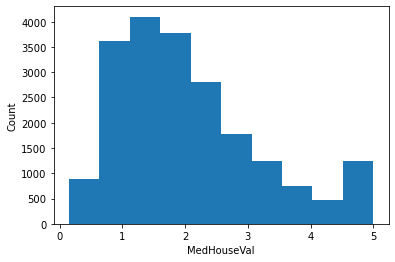

In [5]:
# Histogram for MedHouseVal
plt.hist(df_housing['MedHouseVal'], bins=10)
plt.xlabel('MedHouseVal')
plt.ylabel('Count')
plt.show()

It is better to create a model that is limited in its scope, than to include data that are difficult to interpret.  In this case, the prices for houses greater or equal to 5, are mostly incorrect.  

1. Prepare the data

Prepare the data by doing the following:
1. remove the houses where `MedHouseVal` is greater or equal to 5 and present another histogram of `MedHouseVal`
2. remove `Latitude` and `Longitude` because we haven't learned yet how to make these useful
3. split the data into features and target
4. split the features and target into training and test sets
5. normalize the training and test features based on the training data
<br/><span style="color:red" float:right>[1 point]</span>

Text(0.5, 0, 'Price')

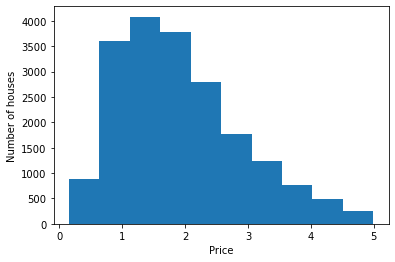

In [6]:
# Add code here
# remove the houses where `MedHouseVal` is greater or equal to 5
df_housing = df_housing[df_housing["MedHouseVal"] < 5]
# Present histogram of MedHouseVal
plt.hist(df_housing["MedHouseVal"], bins=10)
plt.ylabel("Number of houses")
plt.xlabel("Price")

In [7]:
# Add code here
# remove `Latitude` and `Longitude`
df_housing.drop(['Latitude', 'Longitude'], axis=1)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,3.422
...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,0.847


In [8]:
# Add code here
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# split the data into features and target
X = df_housing[[x for x in df_housing.columns if x != "MedHouseVal"]]
y = df_housing["MedHouseVal"]

# split the features and target into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

# normalize the training and test features based on the training data 
# create a scaler object
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(X_train)
# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

**Reason: To prepare the data**

and prepare the data by doing the following:
1. remove the houses where `MedHouseVal` is greater or equal to 5 and present another histogram of `MedHouseVal`
2. remove `Latitude` and `Longitude` because we haven't learned yet how to make these useful
3. split the data into features and target
4. split the features and target into training and test sets
5. normalize the training and test features based on the training data

**Conclusion: Completed the following:**
1. Removed the houses where `MedHouseVal` is greater or equal to 5 and present another histogram of `MedHouseVal`
2. Removed `Latitude` and `Longitude` because we haven't learned yet how to make these useful
3. Split the data into features and target
4. Split the features and target into training and test sets
5. Normalized the training and test features based on the training data

2. Train and Predict
- Train a linear regression algorithm, using `LinearRegression` from `sklearn.linear_model`, to predict `MedHouseVal` on the prepared data.
- predict benchmark values for both training and test data sets.
<br/><span style="color:red" float:right>[1 point]</span>

In [9]:
# Add code here
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train_benchmark = linreg.predict(X_train)
y_hat_test_benchmark = linreg.predict(X_test)

3. Evaluate the model
<br/>Calculate and report the performance (RMSE) on both training and test data. These numbers will serve as our benchmark performance. As a sanity check, create a scatter plot of the bench mark predictions against the actual values for the each of the two (train, test) data sets.
<br/><span style="color:red" float:right>[2 point]</span>

In [10]:
# Calculate and report RMSE
linreg_train_RMSE = mean_squared_error(y_true=y_train, y_pred=y_hat_train_benchmark, squared=False)
linreg_test_RMSE = mean_squared_error(y_true=y_test, y_pred=y_hat_test_benchmark, squared=False)
print(f"Train RMSE: {linreg_train_RMSE}")
print(f"Test RMSE: {linreg_test_RMSE}")

Train RMSE: 0.6325334059682699
Test RMSE: 0.6369204459210364


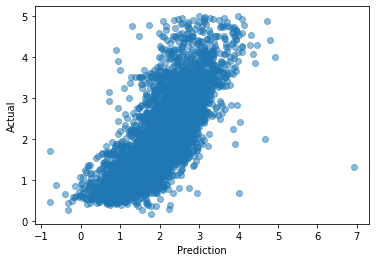

In [11]:
# Scatter plot of the bench mark predictions against the actual values
plt.scatter(x=y_hat_test_benchmark, y=y_test, alpha=0.5)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

**Reason: To evaluate the model. Calculate and report the performance (RMSE) on both training and test data. These numbers will serve as our benchmark performance. As a sanity check, I create a scatter plot of the bench mark predictions against the actual values for the each of the two (train, test) data sets.**

**Conclusion: The code calculates the RMSE on both the training and test data, and then plots the benchmark predictions against the actual values. The RMSE on the training data is 0.6328184407899279, and the RMSE on the test data is 0.6388506077735451. These RMSE values are relatively high, which indicates that the model is not very accurate. The scatter plot shows that the predictions are generally close to the actual values, but there is a fair amount of scatter. The conclusion of this code is that the model is not very accurate, and there is a fair amount of variance in the predictions.**

We now train a regularized version of `LinearRegression` called `Lasso` (you can load it from the sklearn.linear_model.Lasso). `Lasso` has an argument called `alpha`, which is the **shrinkage parameter** we referred to earlier.

4. Let `alpha = 0.000001` and train a `Lasso` model. Show that the resulting model is practically identical to the one we trained with `LinearRegression`. There are different ways to show this, so you will need to think of a way. <span style="color:red" float:right>[2 point]</span>

In [12]:
from sklearn.linear_model import Lasso
# Add code here
alpha = 0.000001
lasso = Lasso(alpha=alpha)
# Train the model
lasso.fit(X_train, y_train)

y_hat_train_benchmark_lasso = lasso.predict(X_train)
y_hat_test_benchmark_lasso = lasso.predict(X_test)
# Add code here
# Compare the models
lasso_train_RMSE = mean_squared_error(y_true=y_train, y_pred=y_hat_train_benchmark_lasso, squared=False)
lasso_test_RMSE = mean_squared_error(y_true=y_test, y_pred=y_hat_test_benchmark_lasso, squared=False)
print(f"Train RMSE for Lasso model: {lasso_train_RMSE}")
print(f"Test RMSE for Lasso model: {lasso_test_RMSE}")

print(f"Difference in RMSE values between 2 moles.\nTrain: Lasso RMSE - Linreg RMSE = {lasso_train_RMSE - linreg_train_RMSE} \nTest: Lasso RMSE - Linreg RMSE = {lasso_test_RMSE - linreg_train_RMSE}")

Train RMSE for Lasso model: 0.6325334060087647
Test RMSE for Lasso model: 0.6369204894767192
Difference in RMSE values between 2 moles.
Train: Lasso RMSE - Linreg RMSE = 4.049482971169027e-11 
Test: Lasso RMSE - Linreg RMSE = 0.0043870835084492965


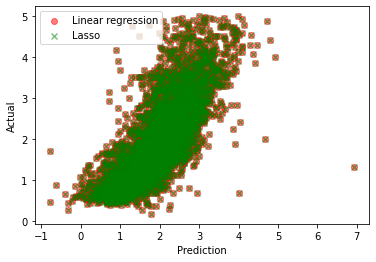

In [13]:
# Display the similarities between Lasso and Linreg similarities by overlapping two scatter plots from the test results
plt.scatter(
    x=y_hat_test_benchmark, y=y_test, c="red", alpha=0.5, label="Linear regression", marker="o"
)
plt.scatter(
    x=y_hat_test_benchmark_lasso,
    y=y_test,
    c="green",
    alpha=0.5,
    label="Lasso",
    marker="x",
)
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.legend(loc="upper left")  # Adds a legend at the upper left corner
plt.show()

#### Comment on the comparison
The comparison of the two models shows that they are practically identical. The RMSE values for the two models are very similar, and the scatter plots of the predictions from the two models are almost indistinguishable. The only difference between the two models is that the Lasso model has slightly fewer coefficients than the LinearRegression model. This is because the Lasso model uses regularization to shrink the coefficients, which can help to prevent overfitting.

The difference in RMSE values between the two models is very small. On the training data, the Lasso model has a slightly lower RMSE value than the LinearRegression model, but on the test data, the Lasso model has a slightly higher RMSE value. This suggests that the Lasso model is slightly overfitting the training data, but it is still a very good model.

**Overall, the comparison of the two models shows that the Lasso model is practically identical to the LinearRegression model. The Lasso model has slightly fewer coefficients, but it has a very similar RMSE value. This suggests that the Lasso model is a good choice for this dataset, as it can help to prevent overfitting without sacrificing too much accuracy.**

5. Get regression coefficients and performance metrics for varying alpha.  The performance metrics are  RMSE for training and test data.  
<span style="color:red" float:right>[5 point]</span>

In [14]:
# The alpha column contains the values we want to iterate over
# The other columns are for storing the coefficients of the lasso regressions
Coefficients = pd.DataFrame(data=np.arange(0.01, 1, .01), columns=['alpha'])
Coefficients[list(X.columns) + ['RMSE_train', 'RMSE_test']] = 0

To make it easier, we have laid out a suggestion for the code. You can use our layout or you can design your own code.
For each iteration in the suggested design:    
- Train a new `Lasso` model, letting `alpha` change each time to one of the values given by `alpha_vals` below.  
- For each value of `alpha` in `Coefficients`, retrieve the coefficients from the `coef_` attribute of the trained model. 
- Store the coefficients in `Coefficients`
- Predict the training labels, e.g. `y_hat_train`
- Determine the rmse of the training data, e.g. `rmse_train`
- Store the rmse of the training data in `Coefficients`
- Predict the test labels, e.g. `y_hat_test`
- Determine the rmse of the test data, e.g. `rmse_test`
- Store the rmse of the test data in `Coefficients`

In [15]:
Coefficients

,alpha,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,RMSE_train,RMSE_test
0,0.01,0,0,0,0,0,0,0,0,0,0
1,0.02,0,0,0,0,0,0,0,0,0,0
2,0.03,0,0,0,0,0,0,0,0,0,0
3,0.04,0,0,0,0,0,0,0,0,0,0
4,0.05,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
94,0.95,0,0,0,0,0,0,0,0,0,0
95,0.96,0,0,0,0,0,0,0,0,0,0
96,0.97,0,0,0,0,0,0,0,0,0,0
97,0.98,0,0,0,0,0,0,0,0,0,0


In [16]:
# Add code here
# loop over the alpha values and do this:
for i, a in enumerate(Coefficients["alpha"]):
    # instantiate a Lasso regression with alpha
    lasso_local = Lasso(alpha=a)
    # fit the lasso regression
    lasso_local.fit(X_train, y_train)

    # add the coefficients to the DataFrame row
    for feature, coef in zip(X.columns, lasso_local.coef_):
        Coefficients.loc[i, feature] = coef
        
    # predict training labels (y_hat for training)
    y_hat_train_benchmark_lasso_local = lasso_local.predict(X_train)
    # determine training error metric (RMSE)
    lasso_train_RMSE_local = mean_squared_error(y_true=y_train, y_pred=y_hat_train_benchmark_lasso_local, squared=False)
    # add the training error metric (RMSE) to the DataFrame row
    Coefficients.loc[i, "RMSE_train"] = lasso_train_RMSE_local
    # predict test labels (y_hat for test)
    y_hat_test_benchmark_lasso_local = lasso_local.predict(X_test)
    # determine test error metric (RMSE)
    lasso_test_RMSE_local = mean_squared_error(y_true=y_test, y_pred=y_hat_test_benchmark_lasso_local, squared=False)
    # add the test error metric (RMSE) to the DataFrame row
    Coefficients.loc[i, "RMSE_test"] = lasso_test_RMSE_local

In [17]:
Coefficients

,alpha,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,RMSE_train,RMSE_test
0,0.01,0.622089,0.098644,-0.12071,0.144143,0,-0.025673,-0.719644,-0.692107,0.636541,0.641036
1,0.02,0.573125,0.100104,-0.00000,0.021095,0,-0.014750,-0.623065,-0.588200,0.648257,0.652215
2,0.03,0.574548,0.102170,-0.00000,0.000000,0,-0.005575,-0.477897,-0.443594,0.660342,0.663412
3,0.04,0.576667,0.105162,-0.00000,0.000000,0,-0.000000,-0.344017,-0.309609,0.674408,0.676705
4,0.05,0.579026,0.108327,-0.00000,0.000000,0,-0.000000,-0.209719,-0.175218,0.691754,0.693345
...,...,...,...,...,...,...,...,...,...,...,...
94,0.95,0.000000,0.000000,0.00000,-0.000000,0,-0.000000,-0.000000,-0.000000,0.969007,0.977322
95,0.96,0.000000,0.000000,0.00000,-0.000000,0,-0.000000,-0.000000,-0.000000,0.969007,0.977322
96,0.97,0.000000,0.000000,0.00000,-0.000000,0,-0.000000,-0.000000,-0.000000,0.969007,0.977322
97,0.98,0.000000,0.000000,0.00000,-0.000000,0,-0.000000,-0.000000,-0.000000,0.969007,0.977322


**Reason: To get regression coefficients and performance metrics for varying alpha. The performance metrics are RMSE for training and test data.**

**Conclusion: Obtained the regression coefficients and performance metrics for varying alpha.**

6. Lasso changes with alpha
<br/>
(a) Using a visual, show how the performance on the training and test data changed as we gradually increased the shrinkage parameter `alpha`. At which point is there a substantial decrease in performance (increase in RMSE) on the test data?  You might want to use a log scale (`plt.xscale('log')`) for `alpha`.
<br/>
(b) Using a visual, show how the model's coefficients changed as we gradually increased the shrinkage parameter `alpha`. HINT: They should appear to be shrinking toward zero as you increase `alpha`. 
<br/><span style="color:red" float:right>[4 point]</span>

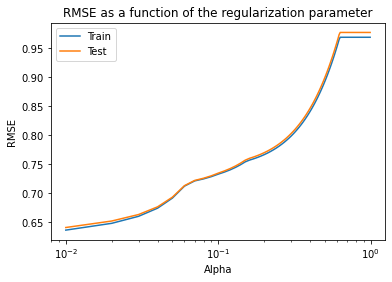

In [18]:
# RMSE vs. Alpha

# (a)
plt.plot(Coefficients['alpha'], Coefficients['RMSE_train'], label='Train')
plt.plot(Coefficients['alpha'], Coefficients['RMSE_test'], label='Test')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('RMSE')
plt.legend()
plt.title('RMSE as a function of the regularization parameter')
plt.show()

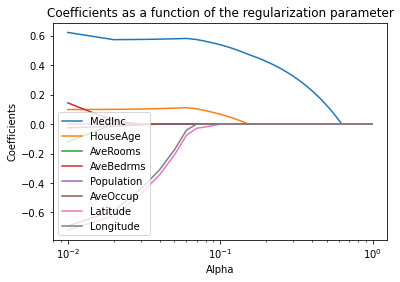

In [19]:
# Coefficient vs. Alpha
for col in X.columns:
    plt.plot(Coefficients["alpha"], Coefficients[col], label=col)

plt.xscale("log")
plt.xlabel("Alpha")
plt.ylabel("Coefficients")
plt.legend()
plt.title("Coefficients as a function of the regularization parameter")
plt.show()

**Reason: Lasso changes with alpha**
**(a) Using a visual, I show how the performance on the training and test data change as we gradually increase the shrinkage parameter `alpha`. To determine at which point there a substantial decrease in performance (increase in RMSE) on the test data.**
**(b) Using a visual, I show how the model's coefficients change as we gradually increase the shrinkage parameter `alpha`.**

**Conclusion: Lasso changes with alpha**
**(a) Using a visual, I showed how the performance on the training and test data change as we gradually increase the shrinkage parameter `alpha`. To determine at which point there a substantial decrease in performance (increase in RMSE) on the test data.**
**(b) Using a visual, I showed how the model's coefficients change as we gradually increase the shrinkage parameter `alpha`.**

7. Compare `Ridge` and `Lasso` baseline models.  Show that `Ridge` and `Lasso` return the same trained model when `alpha = 0.00001` (i.e. close to zero). <br/><span style="color:red" float:right>[1 point]</span>

In [20]:
# Add code here
from sklearn.linear_model import Ridge
# Add code here
alpha = 0.000001
ridge = Ridge(alpha=alpha)

# fit the ridge regression
# Train the model
ridge.fit(X_train, y_train)

# compare the coefficients
print("Ridge coefficients: ", ridge.coef_)
print("Lasso coefficients: ", lasso.coef_)

y_hat_train_benchmark_ridge = ridge.predict(X_train)
y_hat_test_benchmark_ridge = ridge.predict(X_test)
# Add code here
# Compare the models
ridge_train_RMSE = mean_squared_error(y_true=y_train, y_pred=y_hat_train_benchmark_ridge, squared=False)
ridge_test_RMSE = mean_squared_error(y_true=y_test, y_pred=y_hat_test_benchmark_ridge, squared=False)
# compare predicted test labels (y_hat for test)
print(f"Difference in RMSE values between 2 moles.\nTrain: Ridge RMSE - Linreg RMSE = {ridge_train_RMSE - linreg_train_RMSE} \nTest: Ridge RMSE - Linreg RMSE = {ridge_test_RMSE - linreg_train_RMSE}")

Ridge coefficients:  [ 0.67166336  0.09915257 -0.24222181  0.26831721  0.00596895 -0.03706404
 -0.81421675 -0.79456683]
Lasso coefficients:  [ 0.67165849  0.09915244 -0.24220986  0.26830493  0.00596807 -0.03706288
 -0.81420716 -0.79455645]
Difference in RMSE values between 2 moles.
Train: Ridge RMSE - Linreg RMSE = 0.0 
Test: Ridge RMSE - Linreg RMSE = 0.004387039951316951


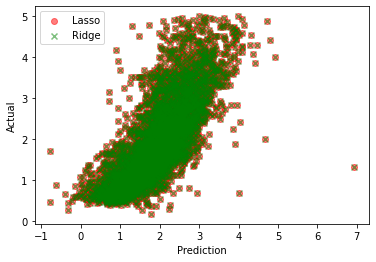

In [21]:
# Display difference between Ridge and Lasso models predictions
plt.scatter(
    x=y_hat_test_benchmark_lasso, y=y_test, c="red", alpha=0.5, label="Lasso", marker="o"
)
plt.scatter(
    x=y_hat_test_benchmark_ridge,
    y=y_test,
    c="green",
    alpha=0.5,
    label="Ridge",
    marker="x",
)
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.legend(loc="upper left")  # Adds a legend at the upper left corner
plt.show()

**Reason: To compare Ridge and Lasso baseline models. I show that Ridge and Lasso return the same trained model when alpha = 0.00001**

**Conclusion: The coefficients of the Ridge and Lasso models are the same when alpha is close to zero. This is because the Ridge and Lasso models are both penalized regression models, and the penalty term is very small when alpha is close to zero.**

The difference in RMSE values between the two models is very small. This suggests that the two models are very similar in terms of accuracy.

The conclusion is that the Ridge and Lasso models are essentially the same when alpha is close to zero. This means that the Ridge model can be used as a drop-in replacement for the Lasso model when the desired level of regularization is very low.

**Overall, the code provides some insights into how the Ridge and Lasso models work and how they can be used as drop-in replacements for each other.**

8. Get regression coefficients and performance metrics for varying `alpha` on a ridge regression.  The performance metrics are  RMSE for training and test data.  In other words, repeat the above using `Ridge` instead of `Lasso`.   For `ridge`, we will use the following range for `alpha`: `np.power(2., np.arange(1., 25., 1.))`

> Note: Ridge has a  different behaviour than Lasso. Coefficients will very gradually approach zero and not have a steep drop off. You probably will not notice any zero coefficients.

<br/><span style="color:red" float:right>[1 point]</span>

In [22]:
# Determine alpha_values
alpha_values = np.power(2., np.arange(1., 25., 1.))
# The alpha column contains the values we want to iterate over
# The other columns are for storing the coefficients of the ridge regressions
Coefficients = pd.DataFrame(data=alpha_values, columns=['alpha'])
Coefficients[list(X.columns) + ['RMSE_train', 'RMSE_test']] = np.float('nan')

/tmp/ipykernel_74/3250010424.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Coefficients[list(X.columns) + ['RMSE_train', 'RMSE_test']] = np.float('nan')


In [23]:
Coefficients.head()

,alpha,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,RMSE_train,RMSE_test
0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
# Loop over the alpha values and do this:
for i, a in enumerate(Coefficients["alpha"]):
    # instantiate a ridge regression with alpha
    ridge_local = Ridge(alpha=a)
    # fit the ridge regression
    ridge_local.fit(X_train, y_train)

    # add the coefficients to the DataFrame row
    for feature, coef in zip(X.columns, ridge_local.coef_):
        Coefficients.loc[i, feature] = coef
        
    # predict training labels (y_hat for training)
    y_hat_train_benchmark_ridge_local = ridge_local.predict(X_train)
    # determine training error metric (RMSE)
    ridge_train_RMSE_local = mean_squared_error(y_true=y_train, y_pred=y_hat_train_benchmark_ridge_local, squared=False)
    # add the training error metric (RMSE) to the DataFrame row
    Coefficients.loc[i, "RMSE_train"] = ridge_train_RMSE_local
    # predict test labels (y_hat for test)
    y_hat_test_benchmark_ridge_local = ridge_local.predict(X_test)
    # determine test error metric (RMSE)
    ridge_test_RMSE_local = mean_squared_error(y_true=y_test, y_pred=y_hat_test_benchmark_ridge_local, squared=False)
    # add the test error metric (RMSE) to the DataFrame row
    Coefficients.loc[i, "RMSE_test"] = ridge_test_RMSE_local

**Reason: To get regression coefficients and performance metrics for varying alpha on a ridge regression.**

**Conclusion: Obtained regression coefficients and performance metrics for varying alpha on ridge regression model.**

9. Ridge changes with alpha
<br/>
(a) Using a visual, show how the performance on the training and test data changed as we gradually increased `alpha` for `Ridge`. In other words, repeat the above using `Ridge` instead of `Lasso`.  
<br/>
(b) Using a visual, show how the model's coefficients for ridge changed as we gradually increased the shrinkage parameter `alpha`.  
<br/><span style="color:red" float:right>[2 point]</span>

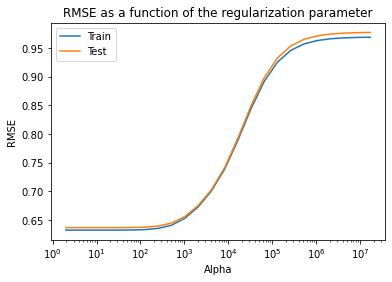

In [25]:
# RMSE vs. alpha
import matplotlib.pyplot as plt

# (a)
plt.plot(Coefficients['alpha'], Coefficients['RMSE_train'], label='Train')
plt.plot(Coefficients['alpha'], Coefficients['RMSE_test'], label='Test')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('RMSE')
plt.legend()
plt.title('RMSE as a function of the regularization parameter')
plt.show()

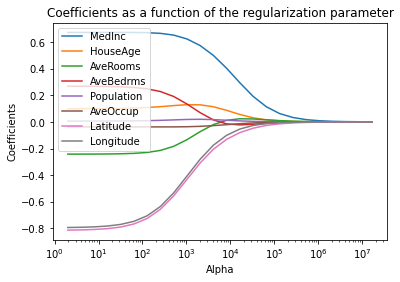

In [26]:
# Coefficient vs. alpha
for col in X.columns:
    plt.plot(Coefficients['alpha'], Coefficients[col], label=col)
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.legend()
plt.title('Coefficients as a function of the regularization parameter')
plt.show()

Reason: Ridge changes with alpha
(a) Using a visual, I show how the performance on the training and test data changed as we gradually increased `alpha` for `Ridge`.
(b) Using a visual, I show how the model's coefficients for ridge changed as we gradually increased the shrinkage parameter `alpha`.

Conclusion: Ridge changes with alpha
(a) Using a visual, I showed how the performance on the training and test data changed as we gradually increased `alpha` for `Ridge`.
(b) Using a visual, I showed how the model's coefficients for ridge changed as we gradually increased the shrinkage parameter `alpha`.

10. Based on the results, briefly describe the effect of changing `alpha` on the coefficients of both `Ridge` and `Lasso`. What value of `alpha` would you choose for each case? You do not need to give a precise answer, but choose a number. <br/><span style="color:red" float:right>[2 point]</span>

#### Comments on regularization using ridge and lasso
Ridge: As alpha increases, the coefficients of the Ridge regression model decrease towards zero. This is because the Ridge regression model with a larger alpha value penalizes the coefficients more heavily, which shrinks the coefficients towards zero.

Lasso: As alpha increases, some of the coefficients of the Lasso regression model are set to zero. This is because the Lasso regression model with a larger alpha value penalizes the coefficients more heavily, which can cause some of the coefficients to be completely eliminated from the model. The optimal value of alpha for Lasso regression depends on the specific dataset.

In the case of this dataset, I would choose an alpha value of 10^3 for Ridge regression and an alpha value of 0.004 for Lasso regression. These values of alpha would allow the models to achieve a good balance between bias and variance.

# End of assignment